In [42]:
import numpy as np
from tqdm import tqdm

# Implementing Dynamic Programming

## Example: The Double Integrator

![Double Integrator](https://underactuated.csail.mit.edu/figures/double_integrator_brick.svg)

In [63]:
granularity = 1

# State space: (x, x_dot), where x between -max_x and max_x and x_dot between -max_x_dot and max_x_dot
max_x = 10
X = np.arange(-max_x, max_x+1, granularity)
max_x_dot = 40
X_dot = np.arange(-max_x_dot, max_x_dot+1, granularity)
S = np.meshgrid((len(X), len(X_dot)))

# Action space: torque, where torque between -max_torque and max_torque
max_torque = 1
A = np.arange(-max_torque, max_torque+1, granularity)

# Goal state = [0, 0], i.e. stop (x_dot=0) at the origin (x=0)
s_goal = [0, 0]
is_goal = lambda s: np.array_equal(s, s_goal)

In [64]:
# Transition function: f(s, a)
delta_t = 1
def f(x, x_dot, a):
    x_dot += np.round(a*delta_t)
    x += np.round(x_dot*delta_t + 0.5*a*delta_t*delta_t)
    return x, x_dot

# Cost function: g(s, a) = minimum time to reach the goal state
def g(s, a):
    return delta_t

In [65]:
def convert_idx_to_xxdot(idx):
    return (idx[0]*granularity - max_x, idx[1]*granularity - max_x_dot)

def convert_xxdot_to_idx(x, x_dot):
    return (int((x + max_x)/granularity), int((x_dot + max_x_dot)/granularity))

def xxdot_in_bounds(x, x_dot):
    return -max_x <= x < max_x and -max_x_dot <= x_dot < max_x_dot

In [66]:
T = max(S.shape)

for t in tqdm(range(T)):
    S_copy = np.copy(S)
    for idx, s in np.ndenumerate(S_copy):
        x, x_dot = convert_idx_to_xxdot(idx)
        if is_goal(idx):
            continue

        S[idx] = max([g((x, x_dot), a) + S_copy[convert_xxdot_to_idx(*f(x, x_dot, a))] for a in A if xxdot_in_bounds(*f(x, x_dot, a))], default=np.inf)

    if np.array_equal(S, S_copy):
        print("Converged at t = ", t)
        break  

 11%|█         | 9/81 [00:00<00:02, 26.01it/s]

Converged at t =  9


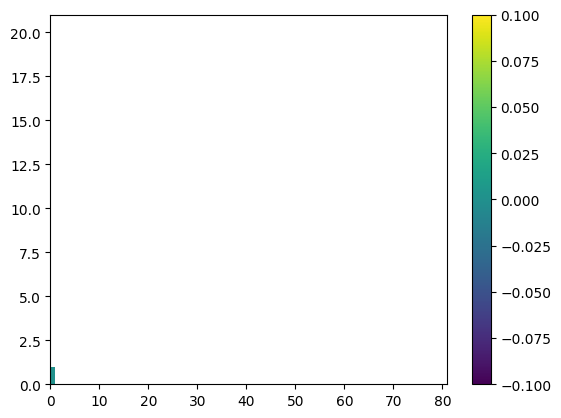

In [73]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
c = ax.pcolormesh(S)
fig.colorbar(c, ax=ax)
plt.show()

(21,) (81,) (21, 81)
(81, 21) (81, 21) (21, 81)


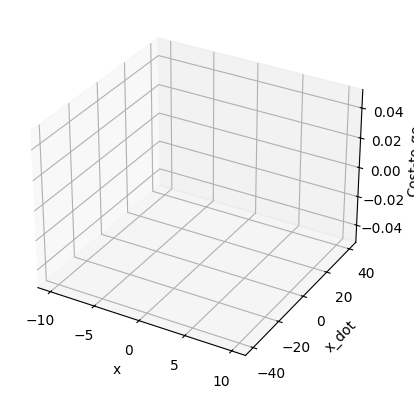

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

XX, YY = np.meshgrid(X, X_dot)
print(X.shape, X_dot.shape, S.shape)
print(XX.shape, YY.shape, S.shape)

ax.plot_surface(XX, YY, S.T, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('x_dot')
ax.set_zlabel('Cost-to-go')
plt.show()

# The General Case

In [27]:
def discrete_dp(S, A, f, g, s_goal, T=None):
    """
        This is an implementation of dynamic programming to solve control problems using discrete optimization. 
        It assumes finite state and action spaces.
        Inputs: 
            S -- discrete state space,
            A -- discrete action space,
            f:SxA --> S -- transition function, 
            g:SxA --> real -- cost function (to be minimized),
            s_goal -- goal state,
            T -- time horizon (default=max(S.shape))
    """
    # Initialize the value function
    if T is None:
        T = max(S.shape)

    cost_to_go = np.zeros(S.shape[0])
    policy = np.zeros(S.shape[0])

    # Iterate over time
    for t in range(T):
        cost_to_go_copy = np.copy(cost_to_go)
        # Iterate over states
        for i, s in enumerate(S): 
            # Compute the cost-to-go for each state-action pair
            cost_to_go[i] = min([g(s, a) + cost_to_go_copy[f(s, a)] for a in A])
            # Update the policy
            policy[i] = np.argmin([g(s, a) + cost_to_go_copy[f(s, a)] for a in A])
    
    return cost_to_go, policy
